In [122]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_prop)
plt.rcParams['axes.unicode_minus'] = False

In [123]:
csv_files = glob.glob(os.path.join('./original_data', '*.csv'))
df_list = [pd.read_csv(f, encoding='utf-8-sig') for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

In [124]:
# 카테고리 분류
drop_col = ['카테고리', '낙찰가율']
df[['대분류', '중분류']] = (df['카테고리'] .str.strip('[]') .str.split(' / ', expand=True))
df['낙찰가(원)'] = df['낙찰가(원)'].replace('-', np.nan)
df.drop(columns=['낙찰가율(%)'], inplace=True)

# 데이터타입 전환
df['개찰일시'] = pd.to_datetime(df['개찰일시'], format='%Y-%m-%d %H:%M', errors='coerce')
price_cols = ['최저입찰가 (예정가격)(원)', '낙찰가(원)']
for col in price_cols:
    df[col] = (df[col].astype(str).str.replace(',', '', regex=False).replace({'비공개': np.nan, '-': np.nan}))
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 개찰일시 기준 정렬
df = df.sort_values(by='개찰일시').reset_index(drop=True)

# 그룹별 집계함수 정의
agg_dict = {
    '대분류':                   'first',
    '중분류':                   'first',
    '물건정보':                 'first',
    '최저입찰가 (예정가격)(원)': 'max',
    '낙찰가(원)':               'max',
    '개찰일시':                 'min',
    '입찰결과':                 'first'
}

# 그룹별 집계 수행
new_df = (df.groupby('일련번호', as_index=False).agg(agg_dict))

# 컬럼명 간소화
new_df = new_df.rename(columns={'최저입찰가 (예정가격)(원)': '최저입찰가', '낙찰가(원)': '낙찰가'})

# 입찰횟쉬 계산
counts = (df.groupby('일련번호')['개찰일시'].nunique().reset_index(name='입찰횟수'))
new_df = new_df.merge(counts, on='일련번호', how='left')

# 온전한 정보만 유지
new_df = new_df[new_df['입찰결과'] == '낙찰']
new_df = new_df.dropna()
new_df.drop(columns=['입찰결과'], inplace=True)
new_df = new_df[new_df['최저입찰가'] != 0]
# df = new_df

# 낙찰가율 계산
# df['낙찰가율'] = (df['낙찰가'] / df['최저입찰가']) * 100
new_df['낙찰가율'] = (new_df['낙찰가'] / new_df['최저입찰가']) * 100

# del new_df

이상치 제거 완료, 최종 행 개수: 39171


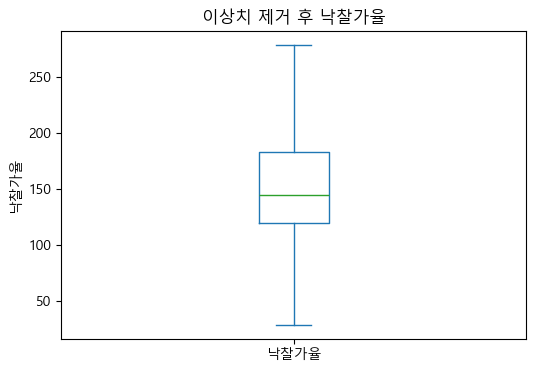

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1) 복사본 생성
df_clean = new_df.copy()

# 2) 루프 돌며 이상치 제거
while True:
    before_cnt = len(df_clean)

    Q1 = df_clean['낙찰가율'].quantile(0.25)
    Q3 = df_clean['낙찰가율'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_clean = df_clean[
        (df_clean['낙찰가율'] >= lower_bound) &
        (df_clean['낙찰가율'] <= upper_bound)
    ].copy()

    after_cnt = len(df_clean)
    # 제거된 행이 없으면 종료
    if before_cnt == after_cnt:
        break
    
df_clean['낙찰가율'] = (df_clean['낙찰가'] / df_clean['최저입찰가']) * 100

print(f"이상치 제거 완료, 최종 행 개수: {after_cnt}")

# 3) 최종 박스플롯
plt.figure(figsize=(6, 4))
df_clean['낙찰가율'].plot.box()
plt.title('이상치 제거 후 낙찰가율')
plt.ylabel('낙찰가율')
plt.show()


<Axes: >

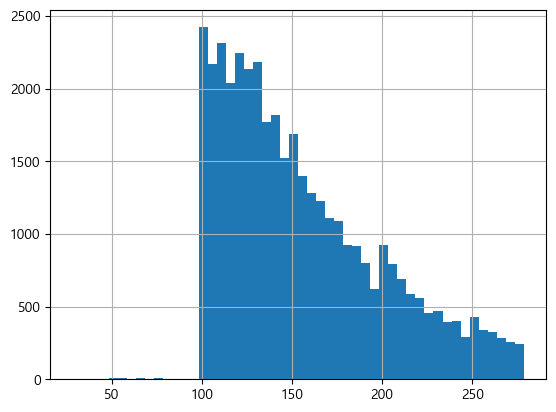

In [126]:
df_clean['낙찰가율'].hist(bins=50)

In [127]:
import pandas as pd

# 1) IQR 반복 계산을 통해 최종 lower_bound, upper_bound 구하기
series = new_df['낙찰가율'].copy()
while True:
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered = series[(series >= lower_bound) & (series <= upper_bound)]
    if len(filtered) == len(series):
        break
    series = filtered

# 2) 원본 new_df에 이상치 여부 표시
new_df['이상치'] = (
    (new_df['낙찰가율'] < lower_bound) |
    (new_df['낙찰가율'] > upper_bound)
).astype(int)

In [131]:
df = new_df

In [132]:
df.to_csv('df.csv', index=False, encoding='utf-8-sig')

In [133]:
df.sample(10)

,일련번호,대분류,중분류,물건정보,최저입찰가,낙찰가,개찰일시,입찰횟수,낙찰가율,이상치
4404,2015-0421-001136,자동차,기타차량,"현대자동차 세원압축진개차 2003년월 6,606cc 수동",8000000.0,13100000.0,2015-04-24 10:00:00,1,163.750000,0
102745,2020-0900-054238,재활용품,재활용품,"대성주방 상업용밥솥 DSSRC-600, 600인용",300000.0,587000.0,2020-09-29 10:00:00,1,195.666667,0
87028,2019-1100-096058,자동차,승합차,"현대자동차(70구8698, 강원) 중형승합 그랜드스타렉스 2497cc",2600000.0,3310000.0,2019-11-26 10:00:00,1,127.307692,0
96134,2020-0500-029955,사무/가구/가전,상업용주방용품및급식자재,"Electrolux 상업용 오븐 IT/AOS-102GA,가스식콤비스티머 외 1건",400000.0,523000.0,2020-06-11 11:00:00,1,130.750000,0
73222,2019-0100-051739,폐기물,고철및금속폐기물,"강설물 9,876kg",2900000.0,3456600.0,2019-02-11 10:00:00,1,119.193103,0
100558,2020-0800-044196,중기,기타중기,"위아 수직형머시닝센터 위아, Hi-Center V50, 테이블크기 1120×510mm",500000.0,5660000.0,2020-08-20 10:00:00,1,1132.000000,1
51392,2017-1200-043548,사무/가구/가전,상업용주방용품및급식자재,상업용 식기세척기,375000.0,422220.0,2017-12-07 10:00:00,1,112.592000,0
48911,2017-1000-038145,자동차,소방및안전및인명구조차,현대/광림 대형화물 광림소방펌프자동차 6606cc,8000000.0,11600000.0,2017-11-06 10:00:00,1,145.000000,0
7724,2015-0641-001217,농/임/축산용기계,농업용기계,구굴기(트랙터용) IS260-400,150000.0,525000.0,2015-06-16 10:00:00,1,350.000000,1
948,2014-1221-001647,이륜차,자전거,"삼천리자전거 자전거 흰색 삼천리 700c 랩터, 흰색 삼천리 700c 파사",40000.0,175000.0,2015-01-06 10:00:00,1,437.500000,1
